# Homework 2 analysis

### Import packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import os
import wrds
import fredapi
import math
import numpy

import matplotlib
from scipy.optimize import minimize

### Import data

Establish WRDS connection

In [2]:
conn = wrds.Connection(wrds_username='wmann')

Loading library list...
Done


One-month risk-free returns:

In [3]:
FF3F = conn.get_table(library='ff_all',table='factors_monthly')
FF3F['month'] = pd.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop('date',axis=1).drop('dateff',axis=1).set_index('month')
riskfree = FF3F.rf.astype('float64')
riskfree = round(riskfree,6)
riskfree = riskfree['1980':'2025']

Gold returns:

In [4]:
Gold = conn.raw_sql("""select comcode, of, date_ from trdstrm.wrds_cmdy_data 
    where comcode = '1865' and of is not null and of <> 5""")
Gold['date_'] = pd.to_datetime(Gold['date_'])
Gold = Gold.sort_values(by='date_')
Gold = Gold.reset_index().resample('ME',on='date_').agg(['last'])
Gold['month'] = Gold.index.to_period('M')
Gold['ret'] = (Gold['of']/Gold['of'].shift())-1
Gold = Gold.set_index('month')
Gold = Gold['ret']
Gold = round(Gold,6)
Gold = Gold['1980':'2025']

Market portfolio returns, measured with VFINX:

In [5]:
VFINX_crsp_fundno = conn.raw_sql("select crsp_fundno, ticker from crsp_q_mutualfunds.fund_hdr where ticker = 'VFINX'").reset_index().crsp_fundno[0]
VFINX = conn.raw_sql("select caldt, mret from crsp_q_mutualfunds.monthly_returns where crsp_fundno = " + str(VFINX_crsp_fundno))
# Convert string date to datetime
VFINX = VFINX.set_index( pd.to_datetime(VFINX.set_index('caldt').index) ).drop('caldt',axis=1)
# Aggregate to monthly level
VFINX['month'] = VFINX.index.to_period('M')
VFINX = (VFINX.set_index('month') + 1).groupby('month').prod() - 1
VFINX.columns = ['VFINX']
VFINX = round(VFINX,6)
VFINX = VFINX['1980':'2025']
# Convert from dataframe with 1 column labeled VFINX, to series
VFINX = VFINX['VFINX']

In [6]:
conn.close()

### Visualizations

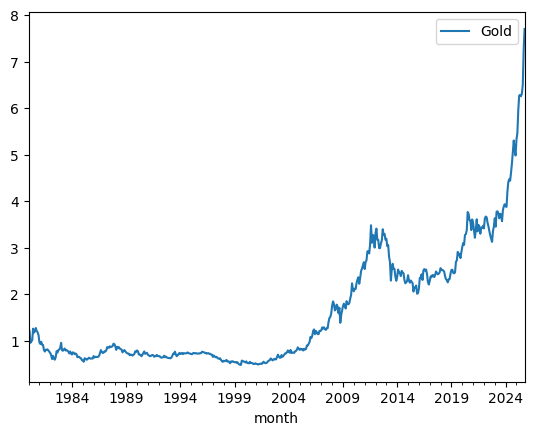

In [7]:
(1+Gold).cumprod().plot(legend=True,label='Gold');

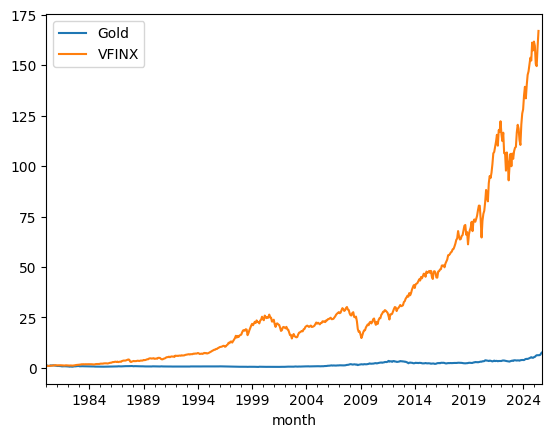

In [8]:
(1+Gold).cumprod().plot(legend=True,label='Gold');
(1+VFINX).cumprod().plot(legend=True,label='VFINX');

Visualize correlations over a short horizon:

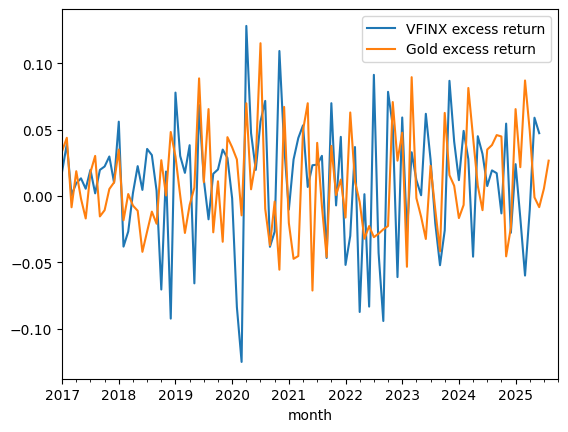

In [9]:
(VFINX - riskfree)['2017':].plot(legend=True,label='VFINX excess return');
(Gold - riskfree)['2017':].plot(legend=True,label='Gold excess return');

### Analysis

In the assignment, I restricted to 2008-2024.

In [10]:
VFINX = VFINX['2008':'2024']
Gold = Gold['2008':'2024']
riskfree = riskfree['2008':'2024']

Save the data to Excel if desired:

In [11]:
# HWdata = pd.concat([VFINX, Gold.to_frame(name='Gold'), riskfree.to_frame(name='rf')],axis=1)
# HWdata = HWdata['2008':'2024']

# try: os.remove("Homework 2 data.xlsx")
# except OSError: pass

# # set up custom ExcelWriter engine to get the date format correct in the output file
# writer = pd.ExcelWriter('Homework 2 data.xlsx', engine='xlsxwriter', datetime_format= "yyyy-mm")

# HWdata.to_excel(writer,sheet_name='Data')

# writer.close()

First save some statistics that we will use.

In [12]:
VFINX_excess_mean = (VFINX-riskfree).mean()
VFINX_excess_vol = (VFINX-riskfree).std()

Gold_excess_mean = (Gold-riskfree).mean()
Gold_excess_vol = (Gold-riskfree).std()

VFINX_Gold_Corr = numpy.corrcoef(VFINX-riskfree,Gold-riskfree)[0,-1]
Gold_VFINX_Covar = Gold_excess_vol*VFINX_excess_vol*VFINX_Gold_Corr

Create functions for calculating portfolio statistics and Sharpe ratios.

In [13]:
def Portfolio_expected_excess_return( Gold_weight ):
    VFINX_weight = 1 - Gold_weight
    return VFINX_weight*VFINX_excess_mean + Gold_weight*Gold_excess_mean

def Portfolio_excess_volatility( Gold_weight ):
    VFINX_weight = 1 - Gold_weight
    return numpy.sqrt( VFINX_weight**2 * VFINX_excess_vol**2 + Gold_weight**2 * Gold_excess_vol**2 + 2*VFINX_weight*Gold_weight*Gold_VFINX_Covar)

def Sharpe_Ratio( Gold_weight ):
    return Portfolio_expected_excess_return(Gold_weight) / Portfolio_excess_volatility(Gold_weight)


Illustrate the curve of possible portfolios that we can form of VFINX and gold (considering only positive weights):

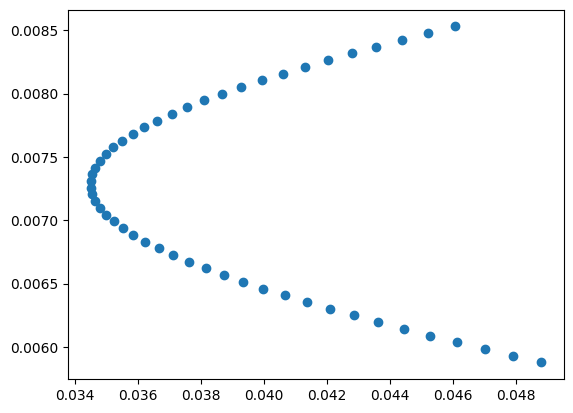

In [14]:
Gold_weights_grid = numpy.linspace(0,1,51)
Portfolios_return_grid = numpy.linspace(0,1,51)
Portfolios_volatility_grid = numpy.linspace(0,1,51)
for i in range(len(Gold_weights_grid)):
    Portfolios_return_grid[i] = Portfolio_expected_excess_return( Gold_weights_grid[i] )
    Portfolios_volatility_grid[i] = Portfolio_excess_volatility( Gold_weights_grid[i] )
matplotlib.pyplot.scatter(Portfolios_volatility_grid,Portfolios_return_grid)
matplotlib.pyplot.show()

Now find the portfolio with the highest Sharpe ratio.

Method 1: Create a grid of portfolio weights and search manually for the highest value.

In [15]:
Gold_weights_grid = numpy.linspace(0,1,101)
Sharpe_ratios_grid = numpy.linspace(0,1,101)
for i in range(len(Gold_weights_grid)): Sharpe_ratios_grid[i] = Sharpe_Ratio(Gold_weights_grid[i]) 

Optimal_Gold_weight = Gold_weights_grid[numpy.argmax(Sharpe_ratios_grid)]
Optimal_VFINX_weight = 1 - Optimal_Gold_weight

print("The portfolio with the highest Sharpe ratio is " +
      '%5.3f' % (100*Optimal_Gold_weight) + "% gold, " +
      '%5.3f' % (100*Optimal_VFINX_weight) + "% VFINX." )
print("It has a Sharpe ratio of " + '%6.5f' % Sharpe_Ratio( Optimal_Gold_weight ) + "." )

The portfolio with the highest Sharpe ratio is 37.000% gold, 63.000% VFINX.
It has a Sharpe ratio of 0.21513.


Method 2: Use an optimizer routine.

In [16]:
Optimal_Gold_weight = minimize( lambda Gold_weight: -Sharpe_Ratio(Gold_weight) , 0 ).x[0]
Optimal_VFINX_weight = 1 - Optimal_Gold_weight

print("The portfolio with the highest Sharpe ratio is " +
      '%5.3f' % (100*Optimal_Gold_weight) + "% gold, " +
      '%5.3f' % (100*Optimal_VFINX_weight) + "% VFINX." )
print("It has a Sharpe ratio of " + '%6.5f' % Sharpe_Ratio( Optimal_Gold_weight ) + "." )

The portfolio with the highest Sharpe ratio is 36.687% gold, 63.313% VFINX.
It has a Sharpe ratio of 0.21513.


Method 3: Use the exact solution in textbook formula 7.13.

In [17]:
formula_713_numerator = Gold_excess_mean*VFINX_excess_vol**2 - VFINX_excess_mean*Gold_VFINX_Covar
formula_713_denominator = Gold_excess_mean*VFINX_excess_vol**2 + VFINX_excess_mean*Gold_excess_vol**2 - (Gold_excess_mean + VFINX_excess_mean)*Gold_VFINX_Covar
Optimal_Gold_weight = formula_713_numerator / formula_713_denominator
Optimal_VFINX_weight = 1 - Optimal_Gold_weight

print("The portfolio with the highest Sharpe ratio is " +
      '%5.3f' % (100*Optimal_Gold_weight) + "% gold, " +
      '%5.3f' % (100*Optimal_VFINX_weight) + "% VFINX." )
print("It has a Sharpe ratio of " + '%6.5f' % Sharpe_Ratio( Optimal_Gold_weight ) + "." )

The portfolio with the highest Sharpe ratio is 36.687% gold, 63.313% VFINX.
It has a Sharpe ratio of 0.21513.


Method 4: Use the exact solution in matrix form as given in the slides from class.

In [18]:
Assets = pd.DataFrame({'Gold excess':Gold-riskfree,'VFINX excess':VFINX-riskfree})
Sigma = Assets.cov()
mu = Assets.mean()
Optimal_weights_unscaled = numpy.linalg.inv(Sigma) @ mu
Optimal_weights = Optimal_weights_unscaled / Optimal_weights_unscaled.sum()
Optimal_Gold_weight, Optimal_VFINX_weight = Optimal_weights

print("The portfolio with the highest Sharpe ratio is " +
      '%5.3f' % (100*Optimal_Gold_weight) + "% gold, " +
      '%5.3f' % (100*Optimal_VFINX_weight) + "% VFINX." )
print("It has a Sharpe ratio of " + '%6.5f' % Sharpe_Ratio( Optimal_Gold_weight ) + "." )

The portfolio with the highest Sharpe ratio is 36.687% gold, 63.313% VFINX.
It has a Sharpe ratio of 0.21513.


# Find optimal portfolio for a given mean-variance investor:

Functions to calculate expected returns and volatilities of efficient portfolios:

In [19]:
def Efficient_portfolio_expected_excess_return(Risky_weight):
    return Risky_weight*Portfolio_expected_excess_return(Optimal_Gold_weight)

def Efficient_portfolio_excess_volatility(Risky_weight):
    return Risky_weight*Portfolio_excess_volatility(Optimal_Gold_weight)

Find the optimal portfolio for A = 6,7,8:

In [20]:
def utility(A,Risky_weight):
    return Efficient_portfolio_expected_excess_return(Risky_weight) - 0.5*A*Efficient_portfolio_excess_volatility(Risky_weight)**2

def exact_weight(A):
    return Portfolio_expected_excess_return(Optimal_Gold_weight) / ( A*Portfolio_excess_volatility(Optimal_Gold_weight)**2 )

for A in (6,7,8):
    
    print("A=" + str(A) + ": ")
    
    weight_grid = numpy.linspace(0,1,101)
    optimal_portfolio = numpy.argmax( [utility(A,w) for w in weight_grid] )
    print("  Weight found by searching over 1%-spaced grid: " + '%5.3f' % weight_grid[ optimal_portfolio ] )

    print("  Exact weight using textbook formula mu / A*sigma^2: " + '%5.3f' % exact_weight(A) )

A=6: 
  Weight found by searching over 1%-spaced grid: 1.000
  Exact weight using textbook formula mu / A*sigma^2: 1.021
A=7: 
  Weight found by searching over 1%-spaced grid: 0.870
  Exact weight using textbook formula mu / A*sigma^2: 0.875
A=8: 
  Weight found by searching over 1%-spaced grid: 0.770
  Exact weight using textbook formula mu / A*sigma^2: 0.766


### Extension: Redo optimal portfolios with silver

We will now expand to have both gold and silver as available assets in addition to VFINX.

At this point we have no choice but to switch to matrix notation, but once you are comfortable with this the whole process is actually much simpler.

Load silver data from WRDS

In [21]:
conn = wrds.Connection(wrds_username='wmann')
Silver = conn.raw_sql("""select comcode, date_, close_ from trdstrm.wrds_cmdy_data 
    where comcode = '3724' """)
conn.close()
Silver['date_'] = pd.to_datetime(Silver['date_'])
Silver = Silver.sort_values(by='date_')
Silver = Silver.reset_index().resample('ME',on='date_').agg(['last'])
Silver['month'] = Silver.index.to_period('M')
Silver['ret'] = (Silver['close_']/Silver['close_'].shift())-1
Silver = Silver.set_index('month')
Silver = Silver['ret']
Silver = round(Silver,6)
Silver = Silver['2008':'2024']

Loading library list...
Done


Save statistics of asset returns: Now this is a vector $\mu$ (mu) of three average returns, and a 3x3 covariance matrix $\Sigma$ (Sigma) of those returns.

In [22]:
Assets = pd.DataFrame({'Gold excess':Gold-riskfree, 'VFINX excess':VFINX-riskfree, 'Silver excess':Silver-riskfree})
Sigma = Assets.cov()
mu = Assets.mean()

Define a function to compute the Sharpe ratio using matrices (this overrides our earlier Sharpe_ratio function):

In [23]:
def Sharpe_ratio(weights):
    return ( weights @ mu ) / numpy.sqrt((weights @ Sigma) @ weights )

Compute optimal risky portfolio by maximizing Sharpe ratio with an optimizer algorithm:

In [24]:
Optimal_weights = minimize( lambda weights: -Sharpe_ratio(weights), [0,1,0] ).x

Optimal_Gold_weight, Optimal_VFINX_weight, Optimal_Silver_weight = Optimal_weights
print("The portfolio with the highest Sharpe ratio is " + \
      '%5.3f' % (100*Optimal_Gold_weight) + "% gold, " + \
      '%5.3f' % (100*Optimal_Silver_weight) + "% silver, " + \
      '%5.3f' % (100*Optimal_VFINX_weight) + "% VFINX." )

print("Its Sharpe ratio is " + '%6.5f' % Sharpe_ratio(Optimal_weights) )

The portfolio with the highest Sharpe ratio is 89.289% gold, -30.158% silver, 95.660% VFINX.
Its Sharpe ratio is 0.23041


Alternatively, calculate the optimal weights directly by starting with the formula $w = \Sigma^{-1}\mu$ for unscaled weights, and then rescaling $w$ to add up to 1:

In [25]:
Optimal_weights_unscaled = numpy.linalg.inv(Sigma) @ mu
Optimal_weights = Optimal_weights_unscaled / Optimal_weights_unscaled.sum()

Optimal_Gold_weight, Optimal_VFINX_weight, Optimal_Silver_weight = Optimal_weights
print("The portfolio with the highest Sharpe ratio is " + \
      '%5.3f' % (100*Optimal_Gold_weight) + "% gold, " + \
      '%5.3f' % (100*Optimal_Silver_weight) + "% silver, " + \
      '%5.3f' % (100*Optimal_VFINX_weight) + "% VFINX." )

print("Its Sharpe ratio is " + '%6.5f' % Sharpe_ratio(Optimal_weights) )

The portfolio with the highest Sharpe ratio is 57.684% gold, -19.483% silver, 61.800% VFINX.
Its Sharpe ratio is 0.23041


The Sharpe ratio between these two approaches is the same for all practical purposes, and the sets of weights that generate that Sharpe ratio have a similar overall logic: A large short position in silver, and roughly equal and bigger long positions in gold and VFINX. But the exact sets of weights that the two approaches find look quite different. This illustrates practical issues that arise as we expand portfolio optimization to include many possible assets and strategies. 

The formula-based approach is "more accurate" in the sense that, if we take the numbers very seriously the Sharpe ratio coming from that approach is just slightly higher than the other approach. However, the difference is beyond the precision of what even a computer can calculate, which is why the search-based approach stopped before finding this precise solution. 

So, if we are just judging portfolios on the Sharpe ratio, there is a wide range of solutions that are practically equivalent. In reality we would probably have some other ways of distinguishing between approaches - perhaps short sales are costly or we want to avoid them completely, etc - and this can be imposed in the optimization procedure as well, but this is beyond the scope of the course.

We can use the formula involving information ratio to show that the Sharpe ratio we calculated above is indeed the highest we could have achieved:

First, find the portfolio of gold and silver that attain the highest possible information ratio with respect to VFINX, and save its IR.

Define a function to calculate IR:

In [26]:
import statsmodels.api as sm

def IR(portfolio_returns):
    OLS_results = sm.OLS(portfolio_returns,sm.add_constant(VFINX-riskfree)).fit()
    return OLS_results.params.const / OLS_results.resid.std()

Then maximize that function using an optimizer:

In [27]:
Optimal_gold_active_weight = minimize( lambda w: -IR(w*(Gold-riskfree) + (1-w)*(Silver-riskfree)) , 0.5 ).x[0]

Optimal_active_portfolio_returns = \
    Optimal_gold_active_weight*(Gold-riskfree) \
    + (1-Optimal_gold_active_weight)*(Silver-riskfree)
Active_IR = IR(Optimal_active_portfolio_returns)
print("The highest possible IR using gold and silver is " + '%6.5f' % Active_IR)

The highest possible IR using gold and silver is 0.13711


Alternatively, there is also a matrix formula to directly calculate the weights that maximize the information ratio. We did not present it in class, but the steps are as follows: 

- Run two separate regressions, one of gold returns on VFINX returns, and another of silver returns on VFINX returns.
- Stack the intercepts from these two regressions as a vector $\alpha$.
- Calculate the 2x2 covariance matrix $\Sigma_\varepsilon$ of the residuals from these regressions.

Then the unscaled weights are given by $w = \Sigma_\varepsilon^{-1} \alpha$, and you again just rescale these to add up to 1.

In [28]:
Gold_results = sm.OLS(Assets['Gold excess'],sm.add_constant(Assets['VFINX excess'])).fit()
Gold_alpha = Gold_results.params.const
Gold_resid = Gold_results.resid

Silver_results = sm.OLS(Assets['Silver excess'],sm.add_constant(Assets['VFINX excess'])).fit()
Silver_alpha = Silver_results.params.const
Silver_resid = Silver_results.resid

Sigma_resid = numpy.cov([Gold_resid, Silver_resid])
active_weights_unscaled = numpy.linalg.inv(Sigma_resid) @ [Gold_alpha,Silver_alpha]
active_weights = active_weights_unscaled / active_weights_unscaled.sum()

Optimal_active_portfolio_returns = (
    Optimal_gold_active_weight*Assets['Gold excess']
    + (1-Optimal_gold_active_weight)*Assets['Silver excess']
)
Active_IR = IR(Optimal_active_portfolio_returns)
print("The highest possible IR using gold and silver is " + '%6.5f' % Active_IR)

The highest possible IR using gold and silver is 0.13711


Now we know the the portfolio of gold and silver that has the highest possible IR.
Label it $A$, and label the VFINX fund as $M$.
Then our formula from class says that the highest SR we can achieve by combining $A$ and $M$ is

$$
SR(*) = \sqrt{ SR_B^2 + IR_A^2 }
$$

In [29]:
SR_VFINX = Assets['VFINX excess'].mean() / Assets['VFINX excess'].std()
print( "The highest attainable Sharpe ratio using VFINX, gold, and silver is " + '%6.5f' % numpy.sqrt( SR_VFINX**2 + Active_IR**2 ) )

The highest attainable Sharpe ratio using VFINX, gold, and silver is 0.23041


As we would hope, this exactly matches the Sharpe ratio that we calculated earlier.